# **Predicting Destinations with the Airbnb Dataset**#

This Capstone project aims to solve the problem of trying to predict a newly registered Airbnb user‘s first choice of travel destination. By analyzing a variety of data such as user informations, country information and user browsing session records, the project aims at coming up with a model that could accurately detect where a user would book his/her first experience from an array of 34000+ cities across 190+ countries.

## Data Wrangling

In the first section of the notebook, I will attempt at cleaning the Airbnb Kaggle Competition Data and wrangling into a form that is suitable for further analysis. The entire data wrangling process will be done using the Python Pandas library.

In [247]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set_style('whitegrid')
plt.style.use('ggplot')
%matplotlib inline

The first step is to load all the data available to us in a Pandas Dataframe and extract basic information such as number of samples, number of null values rows, number of features, etc. The next step would be to deal with the missing values using a suitable method (dropping, interpolating, etc.) and convert certain features into a more suitable form for applying inferential statistics and machine learning algorithms.

### Age, Gender and Population Statistics

In [248]:
# Load the data into DataFrames
df_train = pd.read_csv('train_users_2.csv')
df_test = pd.read_csv('test_users.csv')
sessions = pd.read_csv('sessions.csv')
usergrp = pd.read_csv('age_gender_bkts.csv')
countries = pd.read_csv('countries.csv')

In [249]:
df_agb = pd.read_csv('age_gender_bkts.csv')
df_agb.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


In [250]:
#Check for all features by replacing the key of the mask.
df_agb[df_agb['year'].isnull()]

,age_bucket,country_destination,gender,population_in_thousands,year


There's no missing values in the data file of age_gender_bkts.csv.

As the bin size is reasonably small, we can define a new feature, mean_age which can represent ages without too much loss of information. The mean_age will be the average of the upper and lower range for that particular bin.

In [251]:
#Convert 100+ into a bin.
df_agb['age_bucket'] = df_agb['age_bucket'].apply(lambda x: '100-104' if x == '100+' else x)
#Define mean_age feature
df_agb['mean_age'] = df_agb['age_bucket'].apply(lambda x: (int(x.split('-')[0]) + int(x.split('-')[1]))/2)
df_agb = df_agb.drop('age_bucket', axis=1)
df_agb.head()

,country_destination,gender,population_in_thousands,year,mean_age
0,AU,male,1.0,2015.0,102.0
1,AU,male,9.0,2015.0,97.0
2,AU,male,47.0,2015.0,92.0
3,AU,male,118.0,2015.0,87.0
4,AU,male,199.0,2015.0,82.0


In [252]:
df_agb['country_destination'].value_counts()

US    42
PT    42
IT    42
GB    42
FR    42
CA    42
DE    42
AU    42
ES    42
NL    42
Name: country_destination, dtype: int64

The number of countries is extremely small. It therefore makes sense to use one hot encoding to convert this variables into numerical quantities. We will however reserve this step for the machine learning step.

In [253]:
df_agb['gender'].value_counts()

male      210
female    210
Name: gender, dtype: int64

The gender can also be turned into a categorical binary variable. Let us represent male with 0 and female with 1.



In [254]:
df_agb['gender'] = df_agb['gender'].apply(lambda x: 0 if x == 'male' else 1)
df_agb['gender'].value_counts()

1    210
0    210
Name: gender, dtype: int64

In [255]:
df_agb['year'].value_counts()

2015.0    420
Name: year, dtype: int64

There is only value available for the year feature. Therefore, it makes no sense to keep this feature as it doesn't add any information about the data available to us. We shall drop this feature.

In [256]:
df_agb = df_agb.drop('year', axis=1)
df_agb.head()

,country_destination,gender,population_in_thousands,mean_age
0,AU,0,1.0,102.0
1,AU,0,9.0,97.0
2,AU,0,47.0,92.0
3,AU,0,118.0,87.0
4,AU,0,199.0,82.0


### Country Statistics ###

In [257]:
df_con = pd.read_csv('countries.csv')
df_con

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


As such, we do not need to do any cleaning for this (extremely small) dataset. The statistics given here will have to be incorporated into our training and testing datasets before training our model and/or will have to be used in exploratory data analysis to come up with additional insights.

### Sessions ###

In [258]:
df_ses = pd.read_csv('sessions.csv')
df_ses.head(15)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
5,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,7703.0
6,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,115.0
7,d1mm9tcy42,personalize,data,wishlist_content_update,Windows Desktop,831.0
8,d1mm9tcy42,index,view,view_search_results,Windows Desktop,20842.0
9,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,683.0


In [259]:
df_ses.shape

(10567737, 6)

We will replace the unknown values with NaN to give it some semantic meaning. We can always revert back to unknown should the need arise or should our EDA suggest that labelling unavailable data as unknown values will lead to better predictions.

In [260]:
df_ses['action'] = df_ses['action'].replace('-unknown-', np.nan)
df_ses['action_type'] = df_ses['action_type'].replace('-unknown-', np.nan)
df_ses['action_detail'] = df_ses['action_detail'].replace('-unknown-', np.nan)

C:\Users\mk185318\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


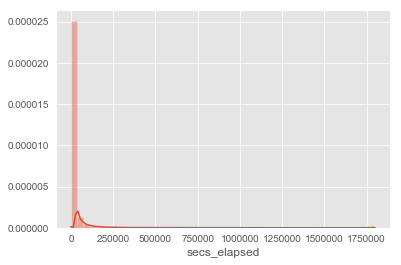

In [261]:
#First, let us have a look at the secs_elapsed variable.
sns.distplot(df_ses[df_ses['secs_elapsed'].notnull()]['secs_elapsed'])

In [262]:
df_ses['secs_elapsed'].describe()

count    1.043171e+07
mean     1.940581e+04
std      8.888424e+04
min      0.000000e+00
25%      2.290000e+02
50%      1.147000e+03
75%      8.444000e+03
max      1.799977e+06
Name: secs_elapsed, dtype: float64

The average number of seconds per session is **19450 seconds** whereas the median value is **1147 seconds**. This suggests a heavily skewed dataset with some outlier observations influencing the mean of the distribution.

In [263]:
len(df_ses[df_ses['secs_elapsed'].isnull()])

136031

There are more than 136,000 fields for which we do not know the value. We need to either drop or interpolate these values. For the time being, let us fill the unavailable values with the median of the distribution. We use median since, as was mentioned earlier, this distribution is heavily influenced by outliers.

In [264]:
median_secs = df_ses['secs_elapsed'].median()
df_ses['secs_elapsed'] = df_ses['secs_elapsed'].fillna(median_secs)

In [265]:
df_ses['secs_elapsed'].describe()

count    1.056774e+07
mean     1.917078e+04
std      8.833430e+04
min      0.000000e+00
25%      2.370000e+02
50%      1.147000e+03
75%      8.193000e+03
max      1.799977e+06
Name: secs_elapsed, dtype: float64

As can be seen above, the interpolation has not significantly altered the summary statistics of the distribution. This is a good option for filling in the null values for the time being.

In [266]:
null_action = df_ses[(df_ses['action_type'].isnull()) | (df_ses['action_detail'].isnull()) | (df_ses['action'].isnull()) ]
null_action.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
6,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,115.0
9,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,683.0


In [267]:
null_action.shape

(2237000, 6)

In [268]:
len(null_action['action'].drop_duplicates())

270

There are over 2.23 million fields that have incomplete information about the action, action type or action detail. This is approximately 20% of the data that we possess. Additionally, there are 270 types of action for which we have null values, so examining them one by one is simply not feasible manually.

Since this is not our training dataset, we will not drop the values. We shall keep because it is possible to extract information even from rows which have null columns.

In [269]:
df_ses[df_ses['device_type'].isnull()]

,user_id,action,action_type,action_detail,device_type,secs_elapsed


In [270]:
df_ses['device_type'] = df_ses['device_type'].replace('-unknown-', np.nan)

In [271]:
df_ses['device_type'].value_counts()

Mac Desktop                         3594286
Windows Desktop                     2658539
iPhone                              2105031
Android Phone                        839637
iPad Tablet                          683414
Android App Unknown Phone/Tablet     273652
Tablet                               139886
Linux Desktop                         28373
Chromebook                            22348
iPodtouch                              8198
Windows Phone                          2047
Blackberry                              979
Opera Phone                              68
Name: device_type, dtype: int64

As can be seen above, there are 13 types of devices that people are using. There is also certain activity for which we do not have data about the device. Let us check how many instances does that account for.

In [272]:
len(df_ses[df_ses['device_type'].isnull()])

211279

As with the action variables, we will not drop these values since this is not the dataset we will be applying our machine learning algorithms to. However, we will replace the unknown strings with NaN to give it more semantic meaning which might be useful in our analysis.

### Training and testing datasets ###

Let us now explore the training dataset which consists of our users for whom we need to predict the first destination.

In [273]:
df_train = pd.read_csv('train_users_2.csv')
df_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [274]:

# training data
df_train.shape

# classification problem, no labels in test data

(213451, 16)

In [275]:
# test data
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62096 entries, 0 to 62095
Data columns (total 15 columns):
id                         62096 non-null object
date_account_created       62096 non-null object
timestamp_first_active     62096 non-null int64
date_first_booking         0 non-null float64
gender                     62096 non-null object
age                        33220 non-null float64
signup_method              62096 non-null object
signup_flow                62096 non-null int64
language                   62096 non-null object
affiliate_channel          62096 non-null object
affiliate_provider         62096 non-null object
first_affiliate_tracked    62076 non-null object
signup_app                 62096 non-null object
first_device_type          62096 non-null object
first_browser              62096 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 7.1+ MB


In [276]:
df_train['gender'] = df_train['gender'].replace('-unknown-', np.nan)
df_train['first_browser'] = df_train['first_browser'].replace('-unknown-', np.nan)

In [277]:
# preview the train_users data
df_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,NaN,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,NaN,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [278]:
# preview the test_users data
df_test.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


## Missing data ##

The missing data comes in the way of NaN, but if we take a look at the DataFrame printed above we can see at the gender column some values being -unknown-. We first transform those values into NaN first. And we can see how much data we are missing. For this purpose let's compute the NaN percentage of each feature.

In [279]:
users.gender.replace('-unknown-', np.nan, inplace=True)
users_nan = (users.isnull().sum() / users.shape[0]) * 100
users_nan[users_nan > 0].drop('country_destination')

date_first_booking            67.733998
gender                        46.990169
age                           42.713584
first_affiliate_tracked        2.208335
first_browser                  9.895227
date_account_created_new      22.535538
date_first_active_new         22.535538
date_account_created_day      22.535538
date_account_created_month    22.535538
date_account_created_year     22.535538
booked                        22.535538
dtype: float64

Because date_first_booking column has a lot of missing values, in this case, we do not need to building this model.

We have quite a lot of NaN in the age and gender wich will yield in lesser performance of the classifiers we will build. The feature date_first_booking has a 58% of NaN values because this feature is not present at the tests users, and therefore, we won't need it at the modeling part.

In [280]:
print(int((df_train.date_first_booking.isnull().sum() / df_train.shape[0]) * 100), "% of missing values at date_first_booking in the training data")

58 % of missing values at date_first_booking in the training data


The other feature with a high rate of NaN was age.

In [282]:
users.age.describe()

count    157851.000000
mean         36.042534
std          11.608794
min           1.000000
25%          28.000000
50%          33.000000
75%          41.000000
max         100.000000
Name: age, dtype: float64

There is some inconsistency in the age of some users as we can see above. It could be because the age inpout field was not sanitized or there was some mistakes handlig the data.

In [283]:
print(sum(users.age > 120))
print(sum(users.age < 18))

0
188


and we have 830 users over 120 years old?

In [284]:
users[users.age > 120]['age'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: age, dtype: float64

It's seems that the weird values are caused by the appearance of 2014. Maybe related with a wrong input being added with the new users??

In [285]:
users[users.age < 18]['age'].describe()

count    188.000000
mean      12.718085
std        5.764569
min        1.000000
25%        5.000000
50%       16.000000
75%       17.000000
max       17.000000
Name: age, dtype: float64

We notice that there are samples for which the age is much greater than 120 (the oldest person is currently 114 years old). This is clearly polluted data and must be removed. Let us replace these values with NaN to denote that we do not know the real age of these people

In [286]:
df_train['age'] = df_train['age'].apply(lambda x: np.nan if x > 120 else x)

In [287]:
users.loc[users.age > 120, 'age'] = np.nan

## Exploration Data Analysis ##

In this section, we will try to visualise and summairise our data to extract new insights about individual features and the relationship they share with the other features. Let us first try and visualise the age and gender statistics of various countries.

### **Country Statistics** ###

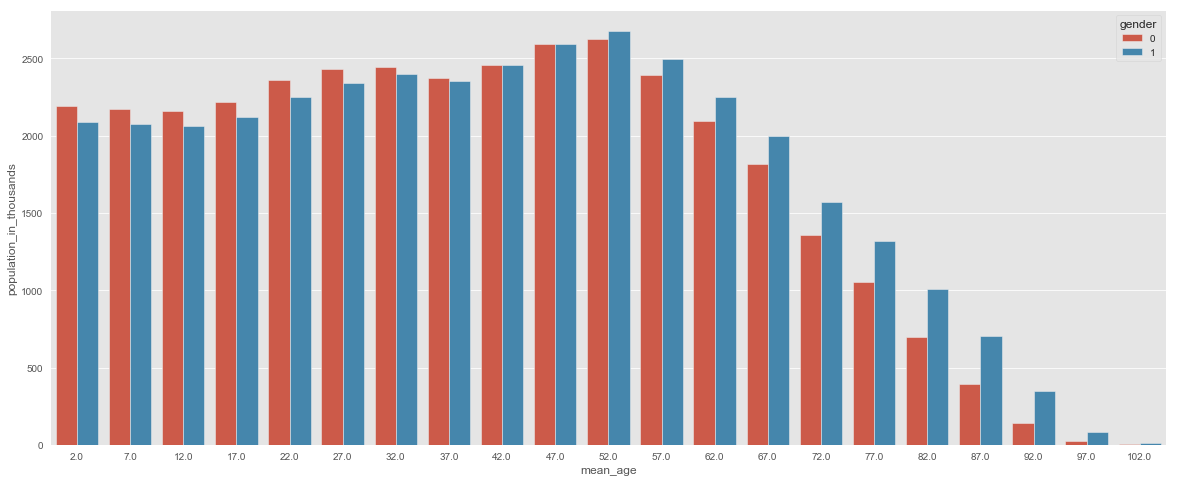

In [288]:
plt.figure(figsize=(20,8))
sns.barplot(x='mean_age', y='population_in_thousands', hue='gender', data=df_agb, ci=None)

**Observations**

- The countries that are represented in this statistic largely consist of an aging population. The largest groups are people with mean ages 47 years and 52 years.
- The distribution resembles a skewed bell curve. The middle aged people occupy the largest share of the population, closely followed by the youth and finally, the old.
- The population counts of young and middle aged people are fairly comparable. But as we transition towards old age (age > 57 years), the population count for every successive bucket decreases steadily.
- One very interesting thing to note is that the sex ratio is skewed towards men for younger age groups but as the mean age increases, the ratio skews more towards women. Women indeed live longer than men.
Next, let us try and graph the population count in each country.

Next, let us try and graph the population count in each country.

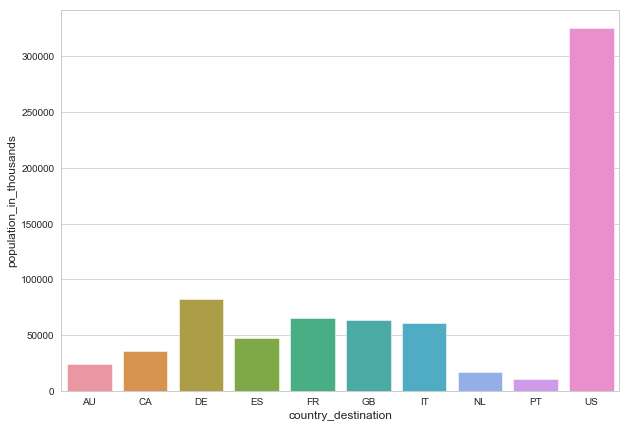

In [289]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,7))
pop_stats = df_agb.groupby('country_destination')['population_in_thousands'].sum()
sns.barplot(x=pop_stats.index, y=pop_stats)

**The United States of America**is clearly the most populated nation amongst the destination countries with a population of over **300 million**. All the other countries in the list have a population less than **100 million.**

Next, let us create a bar plot of the distance of the country from the country of origin (United States of America). We will then construct a scatterplot between the frequency of booking in a country and the distance of the country. My initial hunch is that the further a country, the less likely people are to visit that particular country. There must be at least a small megative correlation between these two quantities.

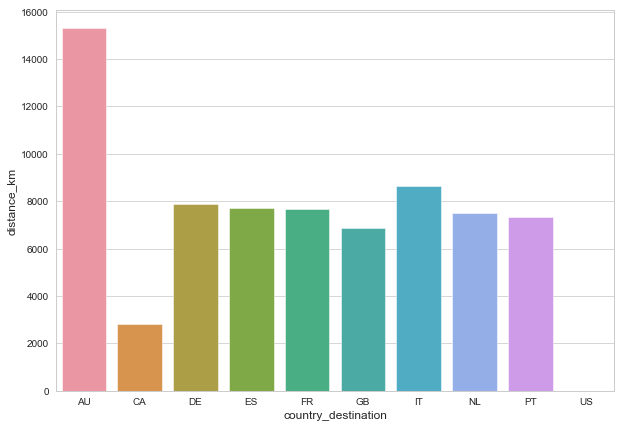

In [290]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,7))
sns.barplot(x='country_destination', y='distance_km', data=df_con)

In [291]:
country_popularity = df_train[(df_train['country_destination'] != 'NDF') & (df_train['country_destination'
] != 'other')]['country_destination'].value_counts()

In [292]:
country_distance = pd.Series(df_con['distance_km'])
country_distance.index = df_con['country_destination']

In [293]:
language_distance = pd.Series(df_con['language_levenshtein_distance'])
language_distance.index = df_con['country_destination']

In [294]:
country_area = pd.Series(df_con['destination_km2'])
country_area.index = df_con['country_destination']

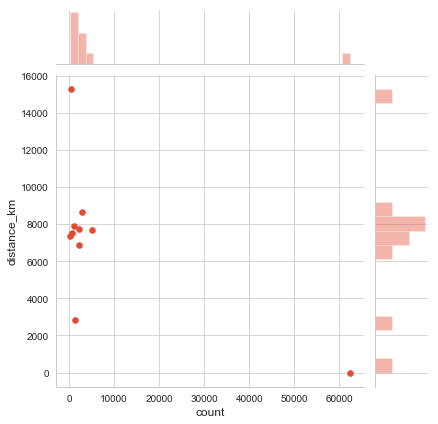

In [295]:
df_dp = pd.concat([country_popularity, country_distance, language_distance, country_area], axis=1,sort=False)
df_dp.columns = ['count', 'distance_km', 'language', 'area']
sns.jointplot(x='count', y='distance_km', data=df_dp)

**There is a strong negative correlation of -0.65.** People overwhelmingly prefer booking in the United States than any other country in the world. We can attribute this preference to distance. Let us check if this holds true for just the interantional countries as well.

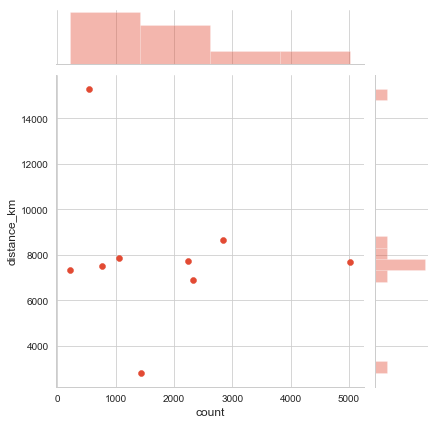

In [296]:
sns.jointplot(x='count', y='distance_km', data=df_dp.drop('US'))

The correlation, with United States out of the equation, is much lower at -0.18. However, there is still a negative correlation between the two quantities.

Next, let us check if the language spoken in a particular country influences the number of bookings in that country. To calculate this metric, we will use the Language Levenshtein Distance of each country's official language from English. This data is already made available to us by Airbnb. Again, like physical distance, my guess is that lower the levenshtein distance, greater the number of bookings in that country.

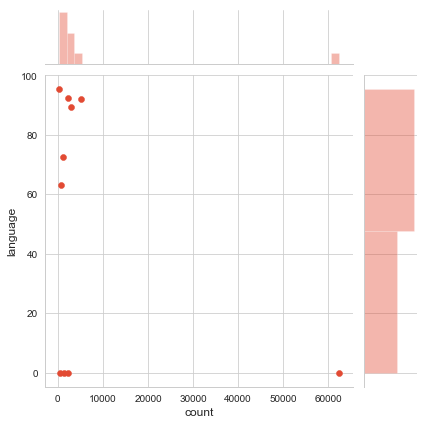

In [297]:
sns.jointplot(x='count', y='language', data=df_dp)

There seems to be a medium negative correlation of -0.38 between the two quantities. This suggests that people indeed prefer countries that speak English. But is that really the case? Let us remove United States, the home country, once again and recalculate our correlation coefficient.

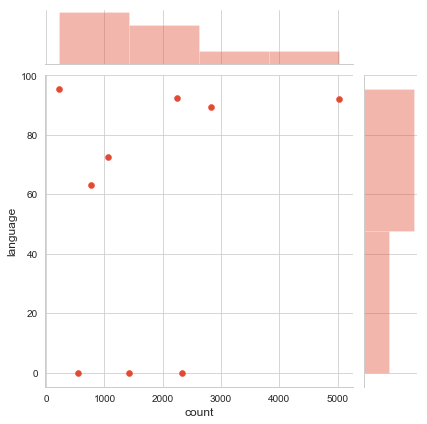

In [298]:
sns.jointplot(x='count', y='language', data=df_dp.drop('US'))

The result of this visualisation is extremely interesting.

- We see that when United States is removed from the list of countries, there is actually a positive correlation between language distance and booking frequency.
- At first glance, this may suggest that people prefer countries with different language (and therefore culture) while travelling abroad.
- Another way of looking at it would be that Europe is an extremely popular travel destination for Americans and they tend to prefer it to other English Speaking countries like Canada and Australia. So this may have nothing to do with language difference as it may have to do with destination preference.

Finally, in this section, let us check if the size of the country has anything to do with booking preference. Like the previous two cases, we have data on the size of each country.

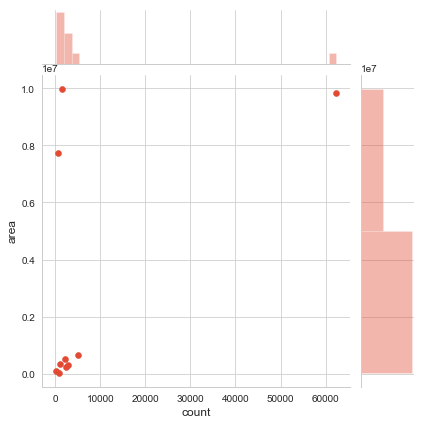

In [299]:
sns.jointplot(x='count', y='area', data=df_dp)

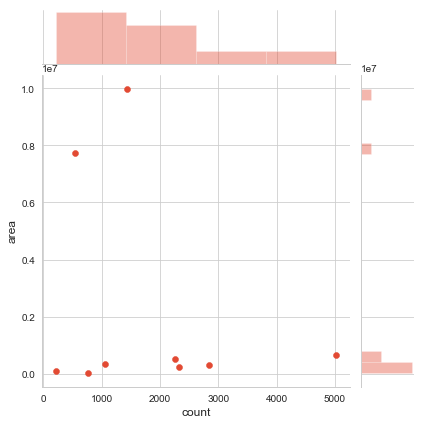

In [300]:
sns.jointplot(x='count', y='area', data=df_dp.drop('US'))

The results with area closely resemble what we've gained from our tests on language distance. Overall, there is a positive correlation between the size of the country and the booking preference. This is largely because the United States is a large country (the second largest in this list).

When the US is removed however, the data showcases a negative correlation. Again, as with the case of language, this may have nothing to do with country size but destination preference. European countries are usually small in size but extremely popular among American tourists.

### **Session Statistics** ##

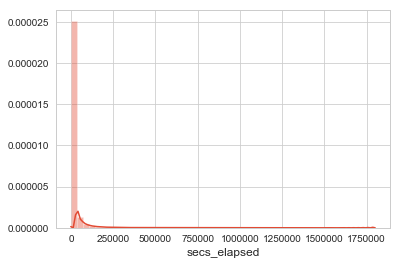

In [301]:
sns.distplot(df_ses[df_ses['secs_elapsed'].notnull()]['secs_elapsed'])

It seems that almost all sessions were less than 5000 seconds long. Let us look deeper into these sessions.

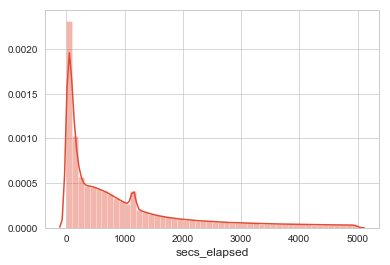

In [302]:
sns.distplot(df_ses[(df_ses['secs_elapsed'].notnull()) & (df_ses['secs_elapsed'] < 5000)]['secs_elapsed'])

We can see that most the number of sessions greater than 1000 seconds decreases almost exponentially. It is fair to assume that most sessions were less than 1000 seconds long. To cross check this, let us look at its share in the total number of sessions.

In [303]:
len(df_ses[df_ses['secs_elapsed'] < 1000])/len(df_ses[df_ses['secs_elapsed'].notnull()])


0.4672638049186879

**Almost 47% of all sessions were less than 1000 seconds long.** This strongly suggests a decreasing exponential distribution of seconds elapsed on each session. In other words, as the number of seconds increases, the number of instances of sessions requiring that much time exponentially decreases.

Finally, in this section, we will construct a bar plot of all devices used by various users in interacting with the Airbnb Website and App.

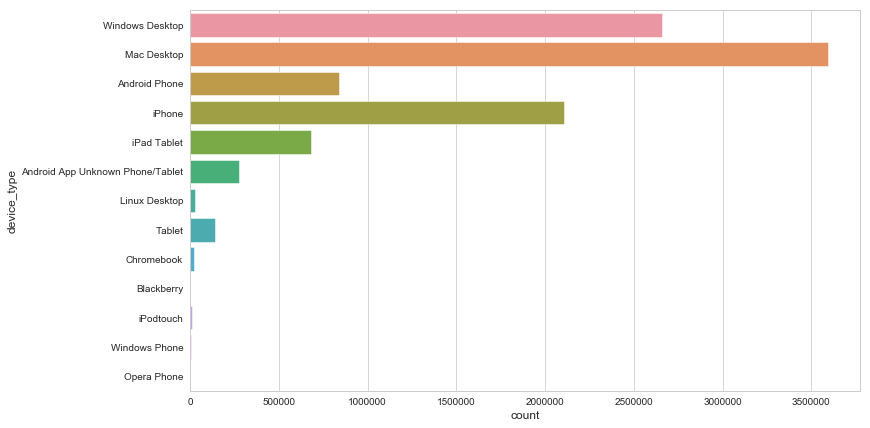

In [304]:
plt.figure(figsize=(12,7))
sns.countplot(y='device_type', data=df_ses)

The **Mac Desktop** is the most popular device among Airbnb Users, followed by the **Windows Desktop.** An interesting insight is that **Apple Products are extremely popular with Airbnb Users.** The iPhone, iPad and the Mac all appear in the list of top 5 most popular devices.

### **Training Users Statistics** ###

In this section, we will try to gain insights on our main dataset: the training dataset. These insights will be directly applicable in the later steps of Feature Engineering and Machine Learning.

The very first step is to plot the frequency of each class.

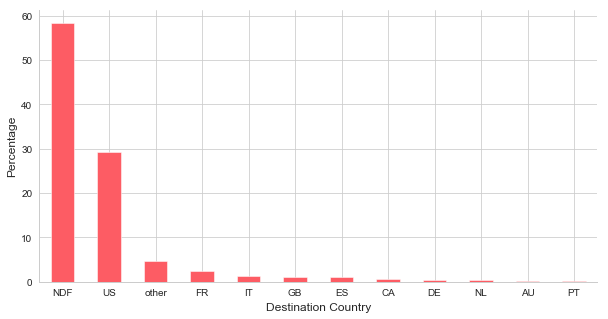

In [305]:
plt.figure(figsize=(10,5))
country_share = df_train['country_destination'].value_counts() / df_train.shape[0] * 100
country_share.plot(kind='bar',color='#FD5C64', rot=0)
plt.xlabel('Destination Country')
plt.ylabel('Percentage')
sns.despine()

As can be seen above, close to **60% of users have never booked an Airbnb.** Among the users that have, they have overwhelmingly chosen **United States as their first destination.** When training our machine learning model, it is of interest to us to separate the bookers from the non bookers. Subsequent classification amongst bookers would yield a high accuracy as we could use the imbalance of classes to our favor.

Next we are going to create stacked barplots to gain insight into various kinds of users (the people who have booked, the countries they have chosen, etc.)

In [306]:
classes = ['NDF','US','other','FR','IT','GB','ES','CA','DE','NL','AU','PT']

In [308]:
def stacked_bar(feature):
    ctab = pd.crosstab([df_train[feature].fillna('Unknown')], df_train.country_destination, dropna=False).apply(lambda x: x/x.sum(), axis=1)
    ctab[classes].plot(kind='bar', stacked=True, colormap='terrain', legend=False)

### **Gender** ###

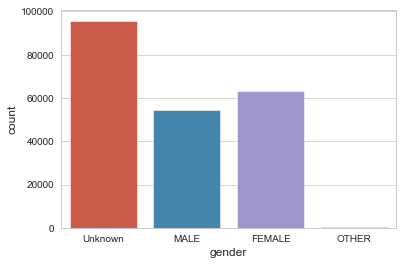

In [309]:
sns.countplot(df_train['gender'].fillna('Unknown'))

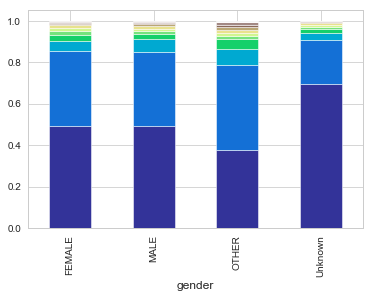

In [310]:
stacked_bar('gender')

We see that the users whose gender is unknown form the majority. Out of the users whose gender is known, there are more females than males. This can suggest two things:

1. There are more female Airbnb Users than male
2. Women are more likely to disclose their gender than men.

One very interesting point of note is that **people who haven't marked their gender are less likely to book an Airbnb.** Also, people who have marked themselves as **'other' are more likely** than any other group to make a booking.

### **Age** ###

Let us now study the ages of users and try to gain insights from it. As we saw in a previous section, we do not have the age data of a considerable chunk of the users. Let us try and plot the distribution for the ones we do.

C:\Users\mk185318\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


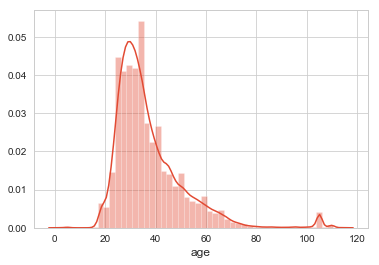

In [311]:
sns.distplot(df_train['age'].dropna())

Are some age groups more likely to book in a particular destination? To answer this question, we will use the box plot and look at the distribution of ages for travellers to a particular country.

(10, 55)

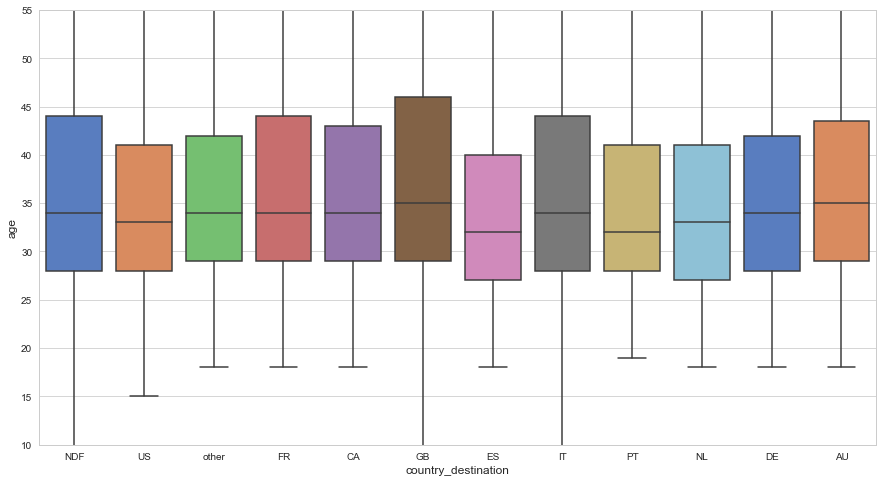

In [312]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='country_destination', y='age', data=df_train, palette="muted", ax =ax)
ax.set_ylim([10, 55])

From the boxplot constructed, we find that the distribution is more or less the same for every country. Great Britain has the highest average age of travellers and **Spain** is more popular amongst younger travellers.

In [313]:
def set_age_group(x):
    if x < 40:
        return 'Young'
    elif x >=40 and x < 60:
        return 'Middle'
    elif x >= 60 and x <= 125:
        return 'Old'
    else:
        return 'Unknown'

In [314]:
df_train['age_group'] = df_train['age'].apply(set_age_group)

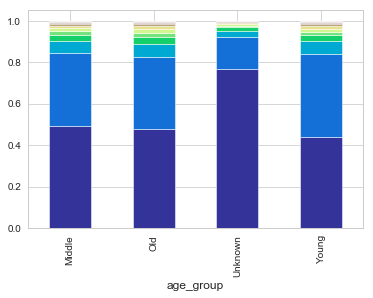

In [315]:
stacked_bar('age_group')

We define a new feature **age_group** to group our users into 4 Age Groups:

- People younger than 40 are labelled as young.
- People aged between 40 and 60 years are labelled as middle aged.
- People aged greater than 60 years are labelled old.
- People with unknown ages are labelled unknown.

We discover that people who have not disclosed their ages **are least likely to book an Airbnb.** Out of the users whose age we know, **Middle Aged People are most likely to book an Airbnb.** Although it must be noted that there isn't a very significant difference amongst the three groups.

### **Signup Method** ###

In a previous section, we already established that basic and Facebook were the most popular signup methods. Google was rarely used.

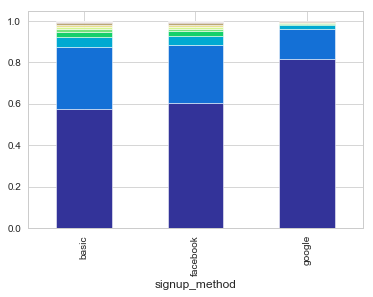

In [317]:
stacked_bar('signup_method')

We discover that people who use basic signup method are most likely to book an Airbnb whereas people who use google are least likely to make a booking.

### **Language** ###

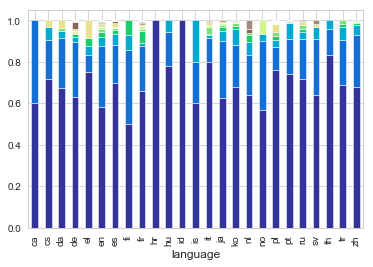

In [318]:
stacked_bar('language')

We see that people who speak **hr** and **id** made almost no bookings. People who spoke **fi** made the most bookings amongst all languages. The large number of languages is also surprising considering that Americans usually converse and interact with their apps primarily in English.

### **Affiliate Channels and Providers** ###

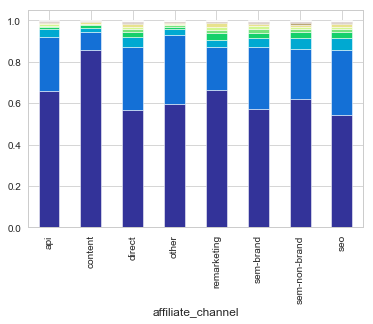

In [320]:
stacked_bar('affiliate_channel')

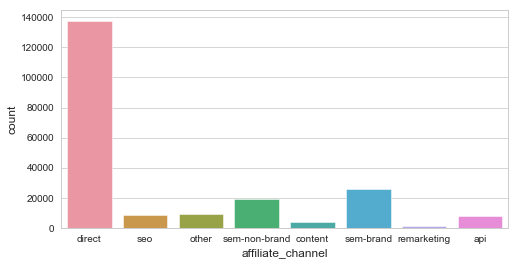

In [321]:
plt.figure(figsize=(8,4))
sns.countplot(df_train['affiliate_channel'])

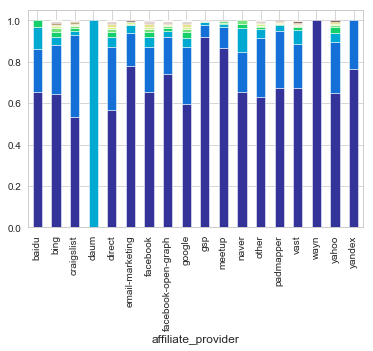

In [322]:
stacked_bar('affiliate_provider')

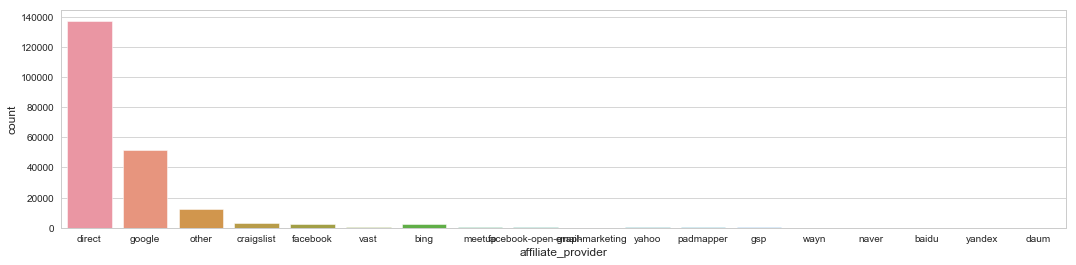

In [323]:
plt.figure(figsize=(18,4))
sns.countplot(df_train['affiliate_provider'])

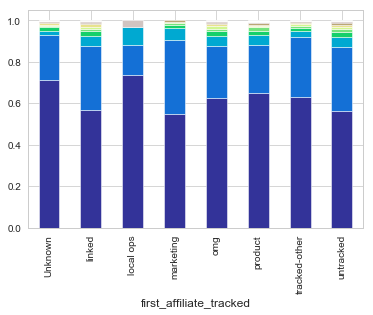

In [324]:
stacked_bar('first_affiliate_tracked')

Some observations from the above visualisations:

- The **Direct Channel** has the most number of conversions to bookings whereas the **Content Channel** has the least.
- Direct and Google are the most popular affiliate providers.
- Wayn has the least percentage of conversions whereas **Daum** has the most. However, we must take this with a pinch of salt as it might be the case that the number of sample points of these categories are extremely few in number (as the count plot suggests).
- Apart from the above, **Google** and **Craigslist** have a good percentage of conversions.
- People with **Marketing** afilliates were most likely to book. People whose first affiliate was tracked as Local Ops or was **Unknown** were least likely.

### **Signup Flow** ###

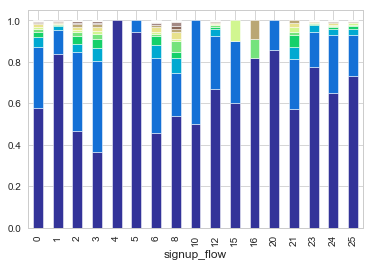

In [325]:
stacked_bar('signup_flow')

The Signup Flow stacked bar chart raises very interesting observations: **people with signup flow 3** are most likely to book an Airbnb. Conversely, people with signup flows **4 and 5 are least likely to convert.**

### **Type of Device, Browser and App Used** ###

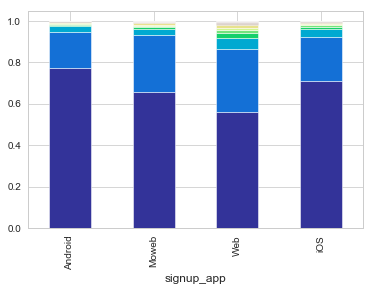

In [326]:
stacked_bar('signup_app')

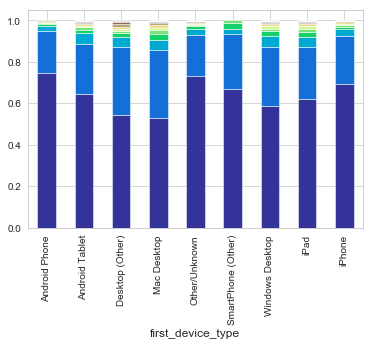

In [327]:
stacked_bar('first_device_type')

As there are too many browsers, we will ignore it for the time being and try to reduce the categories in a later step. For now, we can make the following observations about User Devices:

- Users using the **Web App** are most likely to book an Airbnb whereas **Android Users** are least likely to do so.
- **People with an Android Phone or whose devices were unknown** bought fewer Airbnbs. People on Desktops (Mac or otherwise) bought more.

This strongly suggests that users on their desktop will be more likely to book an Airbnb and Apple Users are more prone to buying on the website whereas Android Users are the least.

### **Dates** ###

Let us first check the trends about when the first accounts were created.

In [328]:
df_train['date_account_created'] = pd.to_datetime(df_train['date_account_created'])


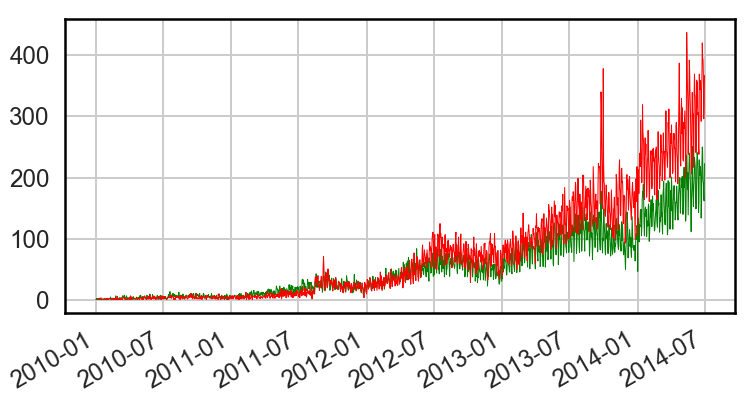

In [329]:
sns.set_style("whitegrid", {'axes.edgecolor': '0'})
sns.set_context("poster", font_scale=1.1)
plt.figure(figsize=(12,6))

df_train[df_train['country_destination'] != 'NDF']['date_account_created'].value_counts().plot(kind='line', linewidth=1, color='green')
df_train[df_train['country_destination'] == 'NDF']['date_account_created'].value_counts().plot(kind='line', linewidth=1, color='red')

The number of non booking users have increased more than the number of booking users as time passed by. This can be attributed to the fact that more people are using the platform just for exploration. Another reason might be that since the user was on the platform for a longer time, s/he was more likely to go ahead and book a space. This directly implies that the **earlier the user had created an account on Airbnb, the more likelier s/he was to actually make a booking.**

With all this in mind, we can nos proceed to the Feature Engineering Step. The Features that we have not yet explored in this section will be explored in the next.

## Inferential Statistics ##

### Gender Preference for Airbnb Bookings ###

In this section, we will be applying statistical tools to gain some inferences and insights into the kind of data we are dealing with and disovering relationships between various features of our dataset.

To begin, let us check if there is a gender based preference for certain countries. In other words, does the gender of a person affect the first country s/he books an Airbnb in? To answer this question we will have to test the relationship between two categorical variables: Gender and Destination Country. Since the number of destination countries is multivariate, the **Chi Square Square Significance Test.**

Before we begin, we will make certain assumptions:

- We will consider only those users who have enlisted their gender as male or female. Unknown and other genders are not included in this analysis.
- We do not consider users who have never booked an Airbnb or have booked in a country not enlisted as a class (NDF and Other).

In [67]:
df_inf = df_train[(df_train['country_destination'] != 'NDF') & (df_train['country_destination'] != 'other') & (df_train['gender'] != 'OTHER') & (df_train['gender'].notnull())]
df_inf = df_inf[['id', 'gender', 'country_destination']]
df_inf.head()

,id,gender,country_destination
2,4ft3gnwmtx,FEMALE,US
6,lsw9q7uk0j,FEMALE,US
7,0d01nltbrs,FEMALE,US
8,a1vcnhxeij,FEMALE,US
10,yuuqmid2rp,FEMALE,US


In [68]:
df_inf['gender'].value_counts()

FEMALE    28833
MALE      24278
Name: gender, dtype: int64

In [69]:
df_inf['country_destination'].value_counts()

US    42151
FR     3297
IT     1790
GB     1563
ES     1530
CA      932
DE      774
NL      532
AU      395
PT      147
Name: country_destination, dtype: int64

Hypothesis Testing
For the hypothesis testing, we define the following:

- Null Hypothesis: There is no relationship between country preference and the sex of the customer.
- Alternate Hypothesis: There is a relationship between country preference and the sex of the customer.

We will assume our significance level, $\alpha$ to be 0.05.

In [71]:
observed = df_inf.pivot_table('id', ['gender'], 'country_destination', aggfunc='count').reset_index()
del observed.columns.name
observed = observed.set_index('gender')
observed

,AU,CA,DE,ES,FR,GB,IT,NL,PT,US
gender,,,,,,,,,,
FEMALE,207,455,358,853,1962,881,1091,254,78,22694
MALE,188,477,416,677,1335,682,699,278,69,19457


In [74]:
chi2, p, dof, expected = stats.chi2_contingency(observed)

In [75]:
chi2

116.87183139602567

In [76]:
p

5.830126955071572e-21

The p-value that we have obtained is less than our chosen significance level. Therefore, we reject the null hypothesis and accept the negating alterate hypothesis. There is a relationship between country preference and the sex of the customer. This information can prove extremely useful to us when performing feature engineering in later steps.

Signup Preferences
In this section, we will try to discover a relationship between the signup method and the signup device. A preliminary querying of our dataframe tells us that most users signup either through the standard basic method or through Facebook. Additionally, they login using either a desktop browser, a mobile browser or a mobile app.

Does the type of device (mobile or computer) affect the signup method to Airbnb? We will try to answer this question here. Again, as aboe, we will make certain assumptions.

- We will ignore the Google Signup Method as there are extremely few instances of it.
- We will consider iOs, Moweb and Android to all be of the Mobile Device Type.

In [77]:
df_signup = df_train[(df_train['signup_method'] != 'google')][['id', 'signup_method', 'signup_app']]
df_signup['device'] = df_signup['signup_app'].apply(lambda x: 'Computer' if x == 'Web' else 'Mobile')
df_signup.head()

,id,signup_method,signup_app,device
0,gxn3p5htnn,facebook,Web,Computer
1,820tgsjxq7,facebook,Web,Computer
2,4ft3gnwmtx,basic,Web,Computer
3,bjjt8pjhuk,facebook,Web,Computer
4,87mebub9p4,basic,Web,Computer


In [78]:
df_signup['signup_method'].value_counts()

basic       152897
facebook     60008
Name: signup_method, dtype: int64

In [79]:
df_signup['device'].value_counts()

Computer    182717
Mobile       30188
Name: device, dtype: int64

**Hypothesis Testing**
Let us now setup our hypothesis test. We will define the following:

Null Hypothesis: There is no relationship between device type and signup method.
Alternate Hypothesis: There is a relationship between device type and signup method.

Assume the significance level $\alpha$ to be at 0.05.

We will be performing the same hypothesis test using two different statistical tools: The Chi Square Significance Test and the Z-Statistic Test. If performed correctly, both tests should give us the same results.

In [80]:
df_signup = df_signup.pivot_table('id', ['device'], 'signup_method', aggfunc='count')
df_signup.index = ['Computer', 'Mobile']
df_signup.columns = ['Basic', 'Facebook']
df_signup

,Basic,Facebook
Computer,131237,51480
Mobile,21660,8528


**Chi Square Test**

In [81]:
chi2, p, dof, expected = stats.chi2_contingency(df_signup, correction=False)

In [82]:
chi2

0.07183824273421707

In [83]:
p

0.7886788661023779

The p-value obtained is higher than our chosen significance level. Therefore, we are not in a position to reject the null hypothesis. It stands. There is no relationship between device type and signup method. Let us perform the same hypothesis test using the Z-Test and compare the results and the p-value obtained.

**Two Sample Significance Test**

Let us now do the same hypothesis testing using the two sample significance test for proportions.

In [84]:
df_signup.loc['Total'] = [ df_signup['Basic'].sum(), df_signup['Facebook'].sum()]
df_signup['Total'] = df_signup['Basic'] + df_signup['Facebook']
df_signup

,Basic,Facebook,Total
Computer,131237,51480,182717
Mobile,21660,8528,30188
Total,152897,60008,212905


In [85]:
fb_prop = df_signup.loc['Mobile', 'Facebook']/df_signup.loc['Total', 'Facebook']
fb_std = df_signup.loc['Mobile', 'Facebook'] * ((1 - fb_prop) ** 2) + df_signup.loc['Computer', 'Facebook'] * ((0 - fb_prop) ** 2)
fb_std = np.sqrt(fb_std/df_signup.loc['Total', 'Facebook'])

fb_prop, fb_std

(0.14211438474870017, 0.3491674188640724)

In [86]:
basic_prop = df_signup.loc['Mobile', 'Basic']/df_signup.loc['Total', 'Basic']
basic_std = df_signup.loc['Mobile', 'Basic'] * ((1 - basic_prop) ** 2) + df_signup.loc['Computer', 'Basic'] * ((0 - basic_prop) ** 2)
basic_std = np.sqrt(basic_std/df_signup.loc['Total', 'Basic'])

basic_prop, basic_std

(0.14166399602346677, 0.34870518816635054)

In [87]:
h0_prop = 0

prop_diff = fb_prop - basic_prop
p_hat = (df_signup.loc['Mobile', 'Basic'] + df_signup.loc['Mobile', 'Facebook'])/(df_signup.loc['Total', 'Basic'] + df_signup.loc['Total', 'Facebook']) 
var_diff = p_hat * (1- p_hat) * (1/df_signup.loc['Total', 'Basic'] + 1/df_signup.loc['Total', 'Facebook'])
sigma_diff = np.sqrt(var_diff)

prop_diff, sigma_diff

(0.0004503887252333971, 0.001680388342245922)

In [88]:
z = (prop_diff - h0_prop) / sigma_diff
z

0.2680265709481359

In [89]:
p = (1-stats.norm.cdf(z))*2
p

0.7886788661023794

The p-value obtained is higher than our chosen significance level. Therefore, we are not in a position to reject the null hypothesis. It stands. **There is no relationship between device type and signup method.**

Also notice that the p-values obtained for Two Sample Significance Test and Chi Square Significance Test (without Correction) is **exactly the same**. We are now in a position to summarise and present our results based on the statistical analysis performed.

**Conclusions**
There is a relationship between gender and Airbnb Country Destination. In other words, the gender influences your country of choice.
There is no relationship between device type and signup method. The two variables are independent of each other.
The results obtained from Chi Square Significance Test and Two Sample Significance Test are exactly the same.